# Monte Carlo Methods

In this notebook, you will write your own implementations of many Monte Carlo (MC) algorithms. 

While we have provided some starter code, you are welcome to erase these hints and write your code from scratch.

### Part 0: Explore BlackjackEnv

We begin by importing the necessary packages.

In [4]:
import sys
import gym
import numpy as np
from collections import defaultdict

from plot_utils import plot_blackjack_values, plot_policy

Use the code cell below to create an instance of the [Blackjack](https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py) environment.

In [5]:
env = gym.make('Blackjack-v0')

Each state is a 3-tuple of:
- the player's current sum $\in \{0, 1, \ldots, 31\}$,
- the dealer's face up card $\in \{1, \ldots, 10\}$, and
- whether or not the player has a usable ace (`no` $=0$, `yes` $=1$).

The agent has two potential actions:

```
    STICK = 0
    HIT = 1
```
Verify this by running the code cell below.

In [6]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


Execute the code cell below to play Blackjack with a random policy.  

(_The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.  The cell is designed for you to get some experience with the output that is returned as the agent interacts with the environment._)

In [7]:
for i_episode in range(3):
    state = env.reset()
    while True:
        print(state)
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        if done:
            print('End game! Reward: ', reward)
            print('You won :)\n') if reward > 0 else print('You lost :(\n')
            print('action = ', action, ', info = ', info)
            break

(19, 8, False)
End game! Reward:  -1.0
You lost :(

action =  1 , info =  {}
(20, 10, False)
End game! Reward:  -1.0
You lost :(

action =  1 , info =  {}
(9, 10, False)
(15, 10, False)
End game! Reward:  -1.0
You lost :(

action =  1 , info =  {}


### Part 1: MC Prediction

In this section, you will write your own implementation of MC prediction (for estimating the action-value function).  

We will begin by investigating a policy where the player _almost_ always sticks if the sum of her cards exceeds 18.  In particular, she selects action `STICK` with 80% probability if the sum is greater than 18; and, if the sum is 18 or below, she selects action `HIT` with 80% probability.  The function `generate_episode_from_limit_stochastic` samples an episode using this policy. 

The function accepts as **input**:
- `bj_env`: This is an instance of OpenAI Gym's Blackjack environment.

It returns as **output**:
- `episode`: This is a list of (state, action, reward) tuples (of tuples) and corresponds to $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$, where $T$ is the final time step.  In particular, `episode[i]` returns $(S_i, A_i, R_{i+1})$, and `episode[i][0]`, `episode[i][1]`, and `episode[i][2]` return $S_i$, $A_i$, and $R_{i+1}$, respectively.

In [8]:
def generate_episode_from_limit_stochastic(bj_env):
    episode = []
    state = bj_env.reset()
    while True:
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

Execute the code cell below to play Blackjack with the policy. 

(*The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.  The cell is designed for you to gain some familiarity with the output of the `generate_episode_from_limit_stochastic` function.*)

In [9]:
for i in range(3):
    print(generate_episode_from_limit_stochastic(env))

[((14, 9, False), 1, 0.0), ((21, 9, False), 0, 1.0)]
[((14, 6, False), 0, -1.0)]
[((19, 10, False), 1, -1.0)]


Now, you are ready to write your own implementation of MC prediction.  Feel free to implement either first-visit or every-visit MC prediction; in the case of the Blackjack environment, the techniques are equivalent.

Your algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `generate_episode`: This is a function that returns an episode of interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

In [10]:
### experimenting with defaultdict

d = defaultdict(lambda: np.zeros(5))

k = (18, 4)
v = 118
d[k] = v
d[(18, 3)] = 103
d[18][2] = 102
#d[k][4] = 104

print(d)
print("d[18] = ", d[18])

print("d[(18, 3)] = ", d[(18, 3)])
print("d[18][3] = ", d[18][3])

print("d[(18, 2)] = ", d[(18, 2)])
print("d[18][2] = ", d[18][2])

print("d[(18, 4)] = ", d[(18, 4)])
print("d[18][4] = ", d[18][4])

### If the default return value from defaultdict is an array, then you can insert items into it with the
### [x][y] syntax above, where x becomes the key and the value is an array of the default size, with y
### indicating the index into that array to store the assigned "value"
### Amazing that python allows apparent mixing of access types in a single data structure!
###
### Using the [x][y] addressing scheme above enforces that x and y are to be integers, so using a tuple
### as the key in this way won't work.  Therefore, although a single defaultdict can store both types of
### key-value pairs in the same structure, their access is not interchangeable. So to get a value out,
### you need to use the same key structure that was used to put it in. And a given data structure could
### therefore hold multiple sets of data that essentially act as if they are in different data structure
### (different objects).  A good way to shoot yourself in the foot!
###
### LESSON:  clearly define (in comments, sigh, since python has no strong typing), exactly what the
###          defaultdict structure is to look like and how it is to be used, then manually enforce that
###          it is used consistently in that way.

defaultdict(<function <lambda> at 0x7fe585435440>, {(18, 4): 118, (18, 3): 103, 18: array([  0.,   0., 102.,   0.,   0.])})
d[18] =  [  0.   0. 102.   0.   0.]
d[(18, 3)] =  103
d[18][3] =  0.0
d[(18, 2)] =  [0. 0. 0. 0. 0.]
d[18][2] =  102.0
d[(18, 4)] =  118
d[18][4] =  0.0


In [11]:
### John modified - using defaultdict with the above lessons in mind to 

def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    # initialize empty dictionaries of arrays
    # returns_sum is the sum of returns for each (s,a) pair over all episodes (and over multiple
    #    visits if the every-visit method is implemented)
    # N is the number of visits experienced for each (s,a) pair
    # Q is the state-action value (estimated) for each state in the blackjack game
    
    # For each of these dicts, the key is a state, and the value is an np array of length 2, whose
    # index is the action and whose value is the intended value of the dict.  Each defaultdict is then
    # effectively a table with each row representing an s and each column representing an a.
    
    # An alternative could be to use the (s, a) tuple as the key and simply let the dict value be the
    # "intended value" of the quantity described; for example
    # Q = defaultdict(lambda: 0.0)
    # Doing so would require revising the use below in the plotting section.
    
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # loop over episodes
    for e in range(1, num_episodes+1):
        # monitor progress
        if e % 1000 == 0:
            print("\rEpisode {}/{}.".format(e, num_episodes), end="")
            sys.stdout.flush()
        
        # Get the next episode
        episode_return = 0.0
        episode = generate_episode(env)
        #print("episode = ", episode)
        
        # loop through the episode from end to beginning (so discount works properly)
        for s in range(len(episode)-1, -1, -1):
            step = episode[s]
            state = step[0]
            action = step[1]
            reward = step[2]
            episode_return = reward + gamma*episode_return
            returns_sum[state][action] += episode_return
            N[state][action] += 1
            #print("step=", s, ", state=", state, ", action=", action, ", reward=", reward)
            #print("N=", sorted(N.items()))
            #print("rewards_sum=", sorted(returns_sum.items()), end="\n\n")
            Q[state][action] = returns_sum[state][action] / N[state][action] #N[] is only populated if it is >= 1
         
        ### Note: it would be more efficient, computationally, if the calculation of averages for Q
        #   would be done after the loop, but that would best be done by defining the defaultdicts with
        #   (s,a) tuples as their keys, as described in an earlier comment, to avoid having unpopulated
        #   action slots in the np arrays, which would have to be guarded for divide-by-zero.  But
        #   redesigning for this tuple-indexed data structure would require redoing the plotting inputs,
        #   and I don't feel like thinking through all that now.
        
    return Q

In [12]:
### Here is the instructor solution

def mc_prediction_q_inst(env, num_episodes, generate_episode, gamma=1.0):
    # initialize empty dictionaries of arrays
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        # generate an episode
        episode = generate_episode(env)
        # obtain the states, actions, and rewards
        states, actions, rewards = zip(*episode)
        print("\nstates=", states)
        print("actions=", actions)
        print("rewards=", rewards)
        # prepare for discounting
        discounts = np.array([gamma**i for i in range(len(rewards)+1)])
        # update the sum of the returns, number of visits, and action-value 
        # function estimates for each state-action pair in the episode
        for i, state in enumerate(states):
            print("/// i=", i, ", state=", state, ", action[i]=", actions[i])
            returns_sum[state][actions[i]] += sum(rewards[i:]*discounts[:-(1+i)])
            print("returns_sum[s][a]=", returns_sum[state][actions[i]])
            N[state][actions[i]] += 1.0
            Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]]
            print("Q[state][action]=", Q[state][actions[i]])
            print("Q=", Q)
    return Q

Use the cell below to obtain the action-value function estimate $Q$.  We have also plotted the corresponding state-value function.

To check the accuracy of your implementation, compare the plot below to the corresponding plot in the solutions notebook **Monte_Carlo_Solution.ipynb**.

Episode 500000/500000.

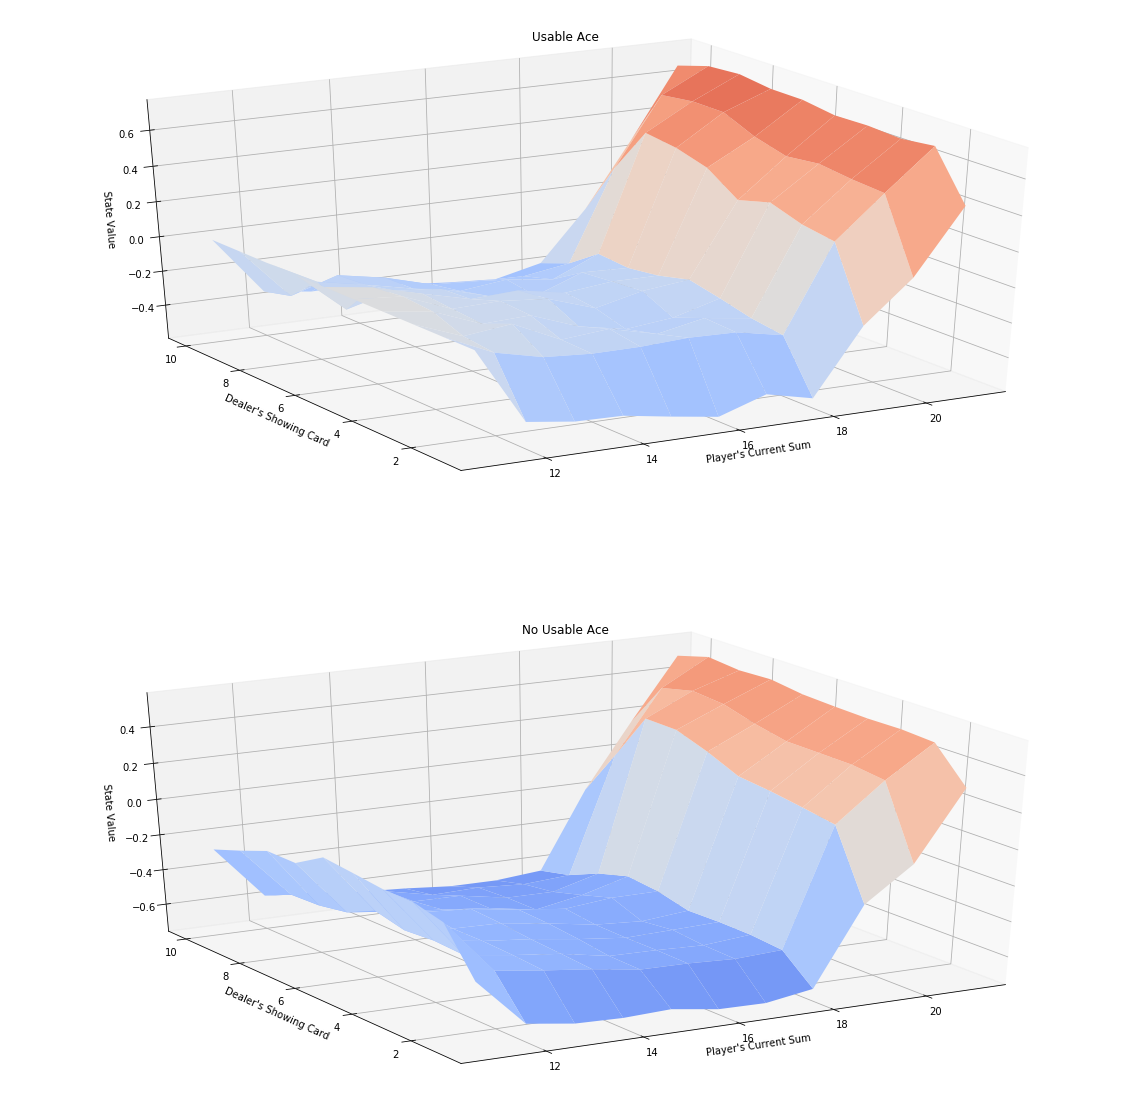

In [16]:
# obtain the action-value function
Q = mc_prediction_q(env, 500000, generate_episode_from_limit_stochastic)
#for i in sorted(Q.items()):
#    print(i)

# obtain the corresponding state-value function
#print("\nQ=", Q)
#for k, v in Q.items():
#    print("k=", k, ", v=", v)
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V_to_plot)

### Part 2: MC Control

In this section, you will write your own implementation of constant-$\alpha$ MC control.  

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `policy`: This is a dictionary where `policy[s]` returns the action that the agent chooses after observing state `s`.

(_Feel free to define additional functions to help you to organize your code._)

In [89]:
### John's support code

import random
from copy import deepcopy

# returns a policy with randomly defined actions for every state
def get_random_policy():
    policy = {}
    for current_sum in range(1, 32):
        for dealer_card in range(1, 11):
            for usable_ace in range(2):
                state = (current_sum, dealer_card, usable_ace)
                policy[state] = random.randint(0, 1)
    return policy

# generates a game episode using a deterministic policy
# bj_env: the blackjack environment from AI gym
# policy: a dictionary of actions for each possible state
def generate_episode_per_policy(bj_env, policy):
    episode = []
    state = bj_env.reset() #gives the initial deal
    while True:
        action = policy[state]
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = deepcopy(next_state)
        if done:
            break
    return episode

# generates a game episode using randomly selected actions
# bj_env: the blackjack environment from AI gym
def generate_random_episode(bj_env):
    episode = []
    state = bj_env.reset() #gives the initial deal
    while True:
        action = random.randint(0, 1)
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = deepcopy(next_state)
        if done:
            break
    return episode

In [122]:
### John's code (skeleton provided by instructor)

def mc_control(env, num_episodes, alpha, gamma=1.0):
    nA = env.action_space.n
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    
    # initialize a random policy
    policy = get_random_policy()
    
    # set epsilon decay params
    if num_episodes > 5:
        ep0 = 1.0
    else:
        ep0 = 0.5
    epf = 0.05
    ep_rate = ep0/num_episodes
    epsilon = ep0
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        # use epsilon-greedy Q to generate the episode
        if random.random() < epsilon:
            episode = generate_random_episode(env)
            #print("\nrandom episode chosen; epsilon = ", epsilon)
        else:
            episode = generate_episode_per_policy(env, policy)
            #print("\npolicy episode chosen; epsilon = ", epsilon)
        #print("episode = ", episode)
        
        # get the return value for the episode, which will be applied to each step
        # NB: this is where discount (gamma) needs to be factored in; I ignored it for now
        g = episode[-1][2]
        
        # loop through each step in the episode
        for step in episode:
            s = step[0]
            a = step[1]
            #g = step[2]
        
            # update the Q table according to the result
            q_prev_print = deepcopy(Q[s])
            q = Q[s][a]
            Q[s][a] = q + alpha*(g - q)
            q_new_print = deepcopy(Q[s])
            #print("Prev Q", s, " = ", q_prev_print, "; new Q = ", q_new_print)
        
            # update the policy according to the new Q table
            # I'm sure there's a slicker way to do this in python, but I'm not that savvy
            prev = policy[s]
            if Q[s][0] > Q[s][1]:
                policy[s] = 0
            else:
                policy[s] = 1
            #print("# Policy for ", s, " was ", prev, ", now ", policy[s])

        # decay epsilon for next loop
        epsilon -= ep_rate
        if epsilon < epf:
            epsilon = epf

    return policy, Q

Use the cell below to obtain the estimated optimal policy and action-value function.  Note that you should fill in your own values for the `num_episodes` and `alpha` parameters.

In [123]:
# obtain the estimated optimal policy and action-value function
policy, Q = mc_control(env, 10000000, 0.01)

Episode 10000000/10000000.

Next, we plot the corresponding state-value function.

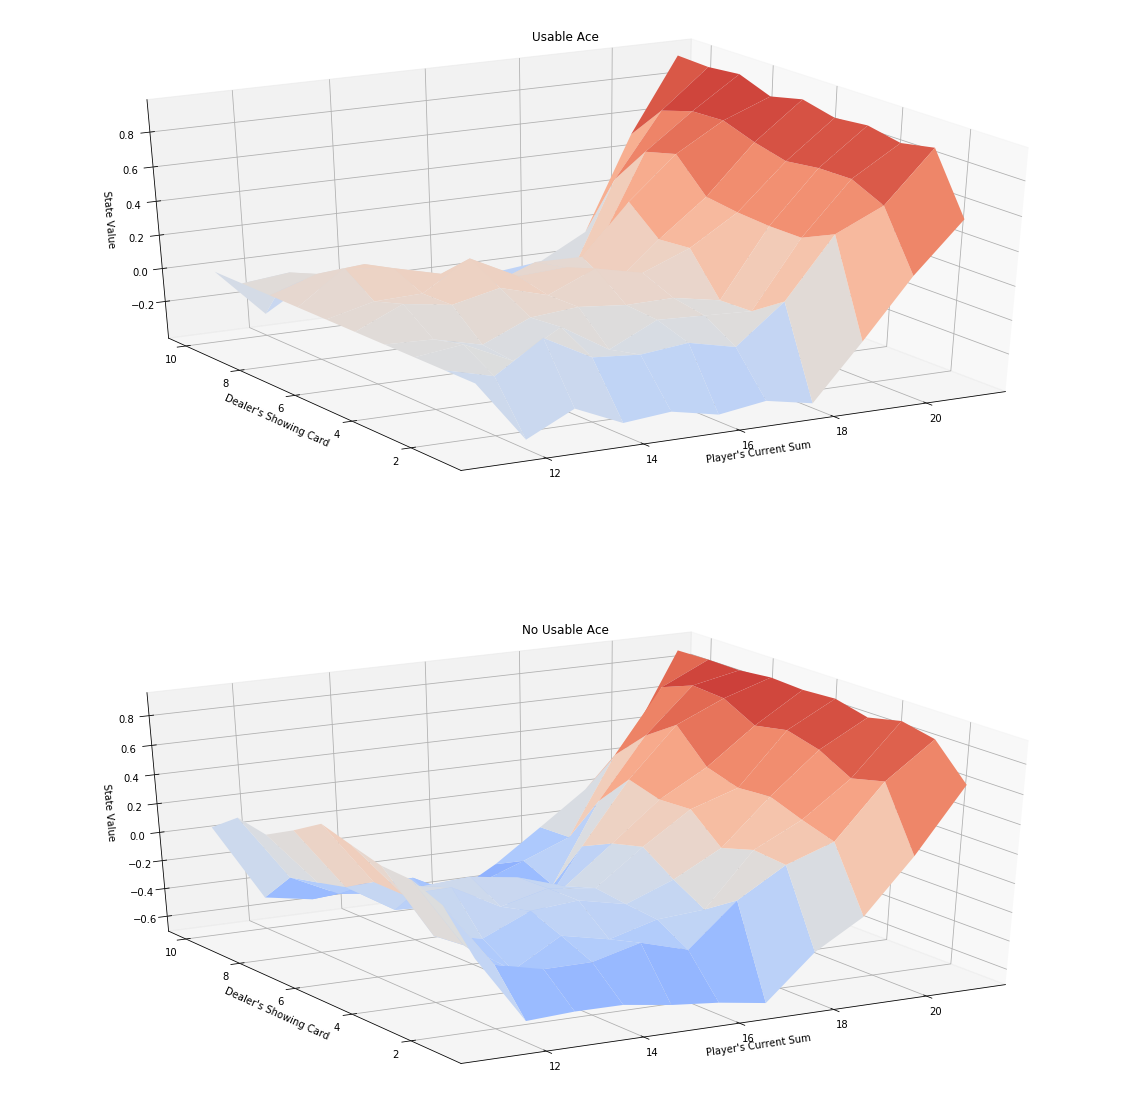

In [124]:
# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V)

Finally, we visualize the policy that is estimated to be optimal.

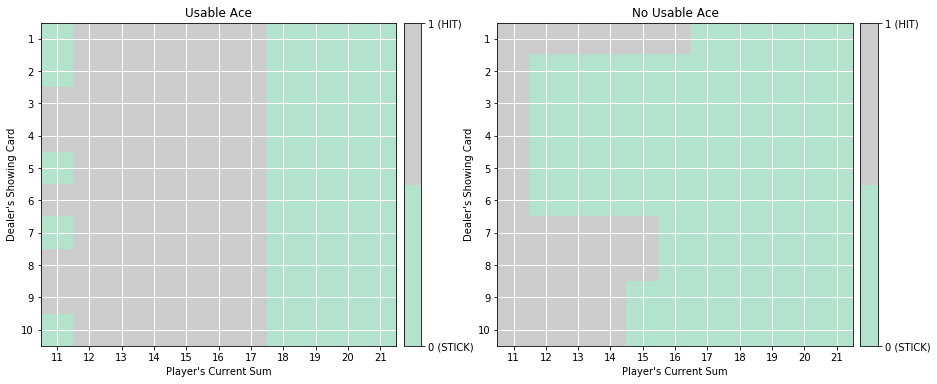

In [125]:
# plot the policy
plot_policy(policy)

The **true** optimal policy $\pi_*$ can be found in Figure 5.2 of the [textbook](http://go.udacity.com/rl-textbook) (and appears below).  Compare your final estimate to the optimal policy - how close are you able to get?  If you are not happy with the performance of your algorithm, take the time to tweak the decay rate of $\epsilon$, change the value of $\alpha$, and/or run the algorithm for more episodes to attain better results.

![True Optimal Policy](images/optimal.png)